In [12]:
# Add the parent directory to the path so that we can import the src module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [13]:
from src.camera import CameraCalibration, Camera
from src.camera.video import VideoStream
from src.segmentation.circledetector import CircleDetector
from src.pose.position_estimation import PositionEstimation
from src.pingpong.ball import BallConstants
from src.pingpong.table import TableConstants
from src.fileutils import DATA_DIR, MODELS_DIR
from src.camera.intrinsic_matrix import find_single_intrinsic_matrix
import src.visualization.plot3D as plot3D
from src.camera import CameraPose
from src.segmentation.adjust_contrast import adjust_contrast
from src.segmentation.yolo_detector import SplitYoloDetector
from src.segmentation.split_image import ImageSplitter

from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation
from ultralytics import YOLOWorld

VideoStream:
	Source: C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\data\calibration\Priyanshu_iPhone13.MOV
	FPS: 212.2765805331427
	Frames: 866
	Resolution: 1920x1080



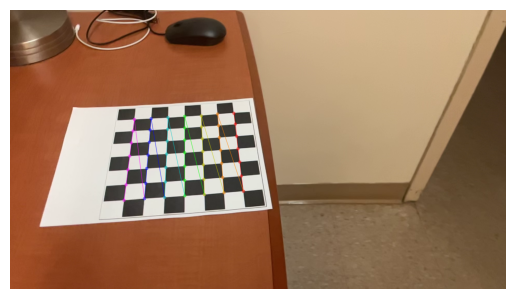

100%|█████████▉| 865/866 [00:30<00:00, 28.78it/s]


array([[     1773.2,           0,      911.69],
       [          0,      2184.9,       544.3],
       [          0,           0,           1]])

In [14]:
calibration_video = VideoStream(DATA_DIR / 'calibration' / 'Priyanshu_iPhone13.MOV')
print(calibration_video)
find_single_intrinsic_matrix(next(calibration_video), show_image=True)
calibration = CameraCalibration.from_calibration_video(tqdm(calibration_video, total=calibration_video.get_length_if_known()))
calibration.intrinsic_matrix

In [15]:
camera = Camera(pose=None, calibration=calibration)
ball = BallConstants()
table = TableConstants()
position_estimator = PositionEstimation(camera, ball, table)

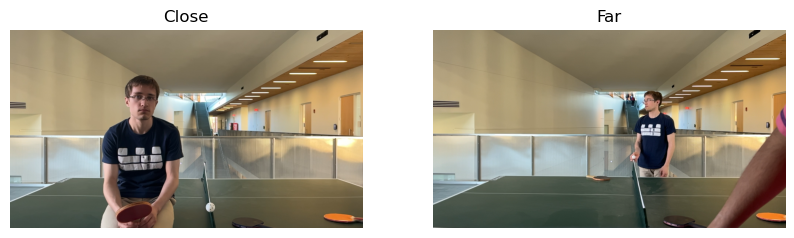

In [16]:
ping_pong_ball_close_image_path = DATA_DIR / 'calibration' / 'Priyanshu_iPhone13' / 'Priyanshu_iPhone13_Net_Close.png'
ping_pong_ball_far_image_path = DATA_DIR / 'calibration' / 'Priyanshu_iPhone13' / 'Priyanshu_iPhone13_Net_Far.png'

# Read images and plot on same plot
ping_pong_ball_close_image = cv2.imread(str(ping_pong_ball_close_image_path))
ping_pong_ball_far_image = cv2.imread(str(ping_pong_ball_far_image_path))

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(ping_pong_ball_close_image, cv2.COLOR_BGR2RGB))
plt.title('Close')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(ping_pong_ball_far_image, cv2.COLOR_BGR2RGB))
plt.title('Far')
plt.axis('off')

plt.show()

We know the length of the net. Therefore, we can test our calibration by checking estimates of the close and far ball positions.
In these images, the camera might not have been setup in precisely the same orientation. Therefore, we can expect to see some error.

4 circles detected
1 circles detected after filtering by color threshold


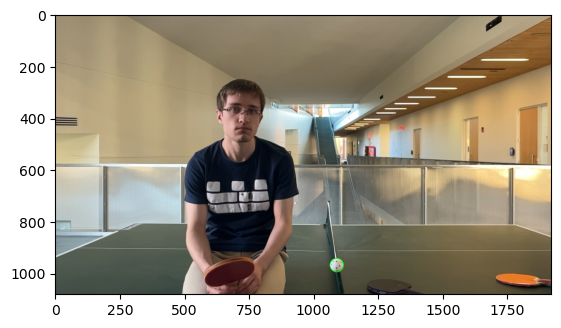

In [17]:
circle_detector = CircleDetector()
circles = circle_detector.hough_circles(ping_pong_ball_close_image, minRadius=10, maxRadius=30, param1=50, param2=30, minDist=20)
print(f"{len(circles)} circles detected")
sensitivity = 50
lower_white = np.array([0,0,255-sensitivity])
upper_white = np.array([255,sensitivity,255])
circles = circle_detector.filter_circles_by_color_threshold(ping_pong_ball_close_image, circles, color_low_hsv=lower_white, color_high_hsv=upper_white, threshold=0.3)
print(f"{len(circles)} circles detected after filtering by color threshold")

aug_img = circle_detector.draw_circles(ping_pong_ball_close_image, circles, color=(0, 255, 0), thickness=2)
_ = plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))


In [18]:
ping_pong_ball = circles[0]
ping_pong_ball_center_x = ping_pong_ball[0]
ping_pong_ball_center_y = ping_pong_ball[1]
ping_pong_ball_radius = ping_pong_ball[2]

print(f'Center: ({ping_pong_ball_center_x}, {ping_pong_ball_center_y}), Radius: {ping_pong_ball_radius}')

ball_position_close = position_estimator.ball_position_camera_reference_frame(ping_pong_ball_center_x, ping_pong_ball_center_y, ping_pong_ball_radius * 2)
print(f'Calculated Ball Position:', ball_position_close)

center_x, center_y, diameter = position_estimator.project_ball_position_camera_reference_frame_to_camera_plane(ball_position_close)

print(f'Projection of ball position: ({center_x}, {center_y}), Radius: {diameter//2}')



Center: (1090, 968), Radius: 26
Calculated Ball Position: [    0.13716     0.26451       1.364]
Projection of ball position: (1090, 968), Radius: 26


1 circles detected
1 circles detected after filtering by color threshold


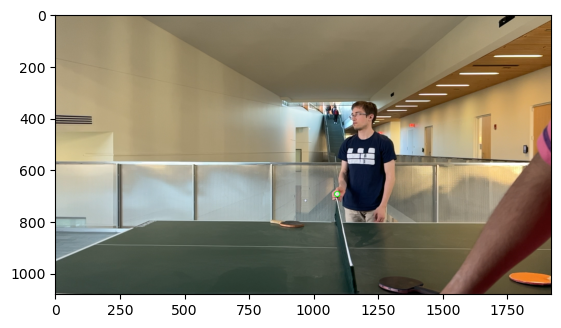

In [19]:
circles = circle_detector.hough_circles(ping_pong_ball_far_image, minRadius=5, maxRadius=20, param1=50, param2=30, minDist=10)
print(f"{len(circles)} circles detected")
sensitivity = 50
lower_white = np.array([0,0,255-sensitivity])
upper_white = np.array([255,sensitivity,255])
circles = circle_detector.filter_circles_by_color_threshold(ping_pong_ball_far_image, circles, color_low_hsv=lower_white, color_high_hsv=upper_white, threshold=0.3)
print(f"{len(circles)} circles detected after filtering by color threshold")

aug_img = circle_detector.draw_circles(ping_pong_ball_far_image, circles, color=(0, 255, 0), thickness=2)
_ = plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))

In [20]:
ping_pong_ball = circles[0]
ping_pong_ball_center_x = ping_pong_ball[0]
ping_pong_ball_center_y = ping_pong_ball[1]
ping_pong_ball_radius = ping_pong_ball[2]

print(f'Center: ({ping_pong_ball_center_x}, {ping_pong_ball_center_y}), Radius: {ping_pong_ball_radius}')

ball_position_far = position_estimator.ball_position_camera_reference_frame(ping_pong_ball_center_x, ping_pong_ball_center_y, ping_pong_ball_radius * 2)
print(f'Calculated Ball Position:', ball_position_far)

center_x, center_y, diameter = position_estimator.project_ball_position_camera_reference_frame_to_camera_plane(ball_position_far)

print(f'Projection of ball position: ({center_x}, {center_y}), Radius: {diameter//2}')


Center: (1092, 694), Radius: 10
Calculated Ball Position: [    0.36062     0.24299      3.5464]
Projection of ball position: (1092, 694), Radius: 10


In [21]:
# In the camera reference frame, we expect the difference 

print(ball_position_far - ball_position_close)
print(f"Expected difference in z-axis: {table.length}")

[    0.22346   -0.021526      2.1824]
Expected difference in z-axis: 2.74


load all images into list
x y z as a numpy array and then set up the camera and the plots

In [22]:
actual_ball_positions = np.array([
    np.array([-0.5, 0, 1]),
    np.array([-0.5, 0, 2]),
    np.array([0.5, 0, 1]),
    np.array([0.5, 0, 2]),
    np.array([0, 0, 0.5]),
    np.array([1, 0, 2]),
    np.array([0, 0, 1]),
    np.array([0, 0, 2]),
    np.array([0, 0, 3]),
    np.array([0, 0.25, 1.5]),
    np.array([0, 0.5, 1.5]),
])

ball = BallConstants(radius = 40e-3) # Initialize ball with defaults

positions_dict = {
    '-0.5x1z': 0,
    '-0.5x2z': 1,
    '0.5x1z': 2,
    '0.5x2z': 3,
    '0.5z': 4,
    '1x2z': 5,
    '1z': 6,
    '2z': 7,
    '3z': 8,
    '0.25y1.5z': 9,
    '0.5y1.5z': 10,
}

In [23]:
# Define the camera pose, we will plot it
camera_position = np.array([0, 0, 0])
camera_orientation = Rotation.from_euler('xyz', [0, 0, 0], degrees=True)
camera = CameraPose(camera_position, camera_orientation, mirror_y=False)

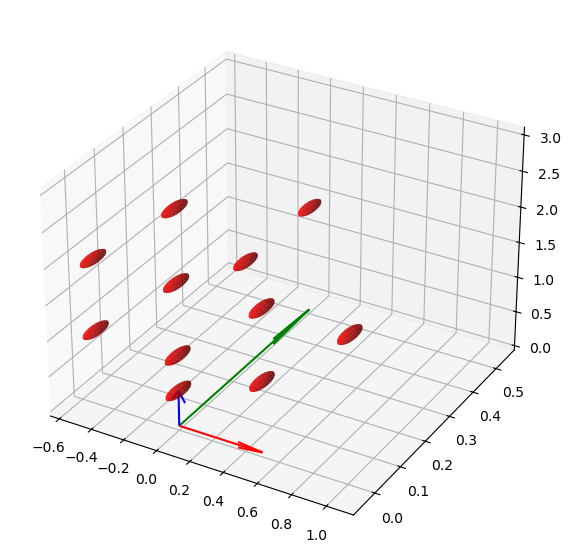

In [24]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

plot3D.plot_camera(ax, camera)
plot3D.plot_balls(ax, ball, actual_ball_positions, color='red')
plt.show()

In [25]:
pictures_dict = {}

directory = DATA_DIR / 'calibration' / 'Priyanshu_iPhone13'

# Iterate over png files with glob
for file in directory.glob('*.png'):

    filename_without_extension = file.stem
    if "Net" in filename_without_extension:
        continue

    # Read the image using OpenCV    
    image = cv2.imread(str(file))
        
    # Check if the image was successfully loaded
    if image is not None:
        # Add the image to the dictionary with filename as key
        pictures_dict[filename_without_extension] = image
    else:
        print(f"Failed to load image: {file}")

In [26]:
print(pictures_dict.keys())

dict_keys(['-0.5x1z', '-0.5x2z', '0.25y1.5z', '0.5x1z', '0.5x2z', '0.5y1.5z', '0.5z', '1x2z', '1z', '2z', '3z', 'Priyanshu_iPhone13_Net_Close', 'Priyanshu_iPhone13_Net_Far'])


In [27]:
# Init yolo
model = YOLOWorld(str(MODELS_DIR / 'yolo' / 'yolov8l-world.pt'))
model.set_classes(['person', 'sports ball', 'ball', 'ping pong ball', 'orange ball'])
ball_classes = {1, 2, 3, 4}

model.conf = 0.01
model.iou = 0.1

# Split the frame into smaller overlapping regions
split_height = pictures_dict["1z"].shape[0]//1
split_width = pictures_dict["1z"].shape[1]//1
overlap = 0.2
splitter = ImageSplitter(split_height=split_height, split_width=split_width, overlap=overlap)

detector = SplitYoloDetector(model, splitter, ball_classes = ball_classes, background_diff_threshold=0.3)

ball_positions = list()

Bounding box [153, 461, 226, 525] detected with confidence 0.5557293891906738
Box Center: (189, 493), Min Length: 64
Ball Position -0.5x1z: [   -0.45168   -0.026021      1.1083]


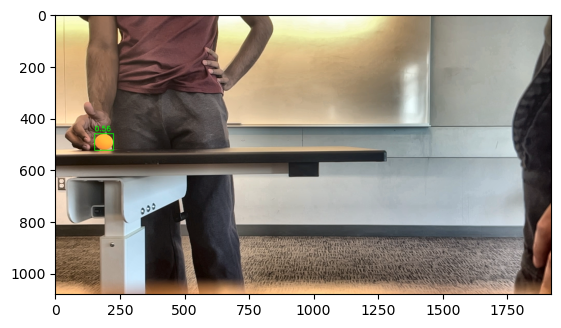

Bounding box [633, 450, 667, 482] detected with confidence 0.5561695694923401
Box Center: (650, 466), Min Length: 32
Ball Position -0.5x2z: [   -0.32711   -0.079434      2.2165]


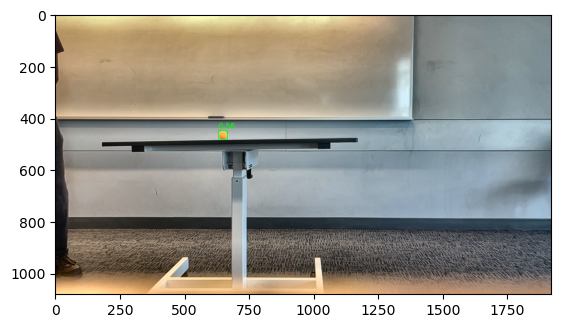

No bounding box detected for 0.25y1.5z
Bounding box [1640, 517, 1713, 580] detected with confidence 0.6249611973762512
Box Center: (1676, 548), Min Length: 63
Ball Position 0.5x1z: [    0.48528   0.0019065      1.1259]


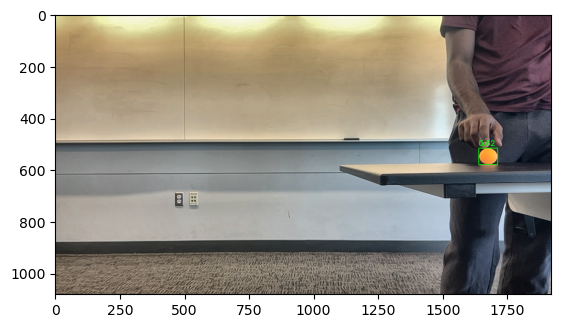

Bounding box [1379, 558, 1414, 591] detected with confidence 0.5069990158081055
Box Center: (1396, 574), Min Length: 33
Ball Position 0.5x2z: [    0.58704    0.029217      2.1494]


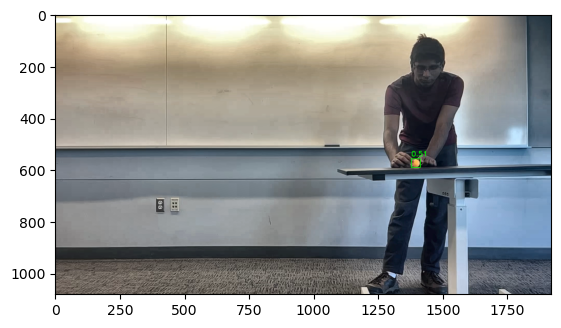

Bounding box [994, 60, 1037, 105] detected with confidence 0.4284844398498535
Box Center: (1015, 82), Min Length: 43
Ball Position 0.5y1.5z: [   0.096104    -0.34902      1.6495]


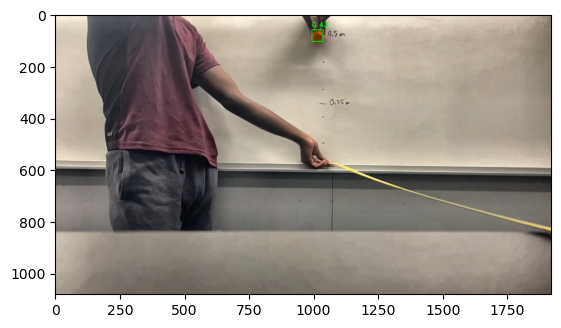

Bounding box [868, 441, 988, 561] detected with confidence 0.9264176487922668
Box Center: (928, 501), Min Length: 120
Ball Position 0.5z: [  0.0054372   -0.011714     0.59107]


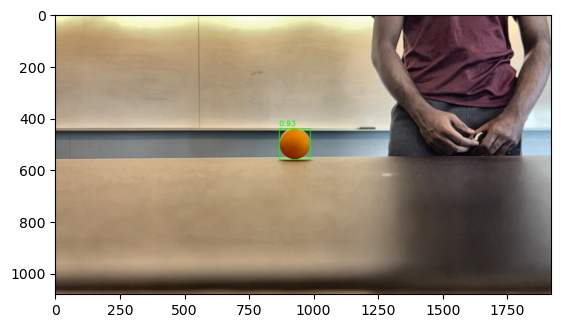

Bounding box [1812, 510, 1851, 542] detected with confidence 0.9001259803771973
Box Center: (1831, 526), Min Length: 32
Ball Position 1x2z: [     1.1491   -0.018565      2.2165]


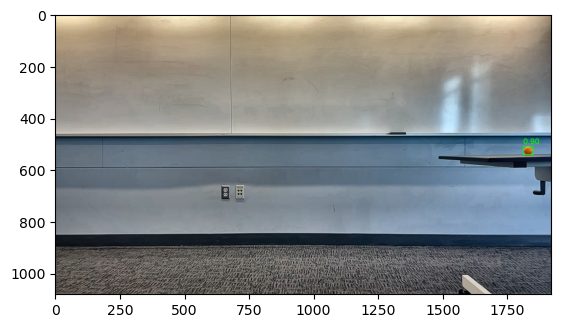

Bounding box [936, 531, 1004, 596] detected with confidence 0.6997050642967224
Box Center: (970, 563), Min Length: 65
Ball Position 1z: [   0.035884   0.0093394      1.0912]


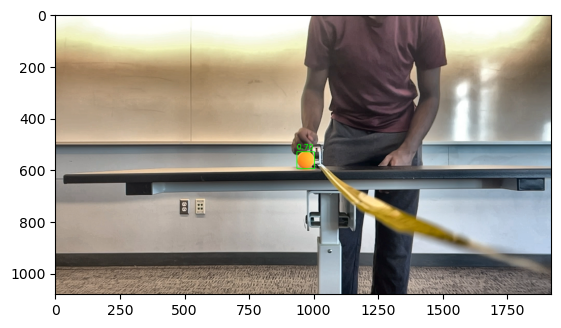

No bounding box detected for 2z
No bounding box detected for 3z
Bounding box [1063, 939, 1117, 994] detected with confidence 0.3443867862224579
Box Center: (1090, 966), Min Length: 54
Ball Position Priyanshu_iPhone13_Net_Close: [    0.13208     0.25351      1.3135]


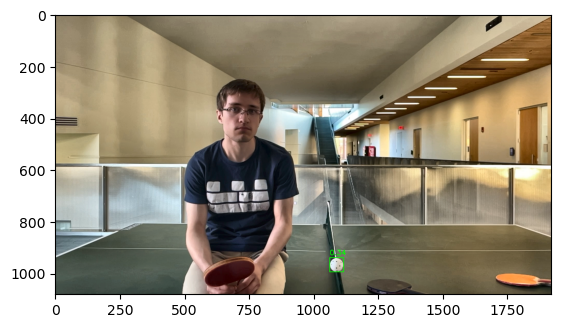

No bounding box detected for Priyanshu_iPhone13_Net_Far


In [28]:

for k, frame in pictures_dict.items():
    frame = adjust_contrast(frame)
    box, conf = detector.detect(frame, yolo_verbose = False, debug_plots = False)
    annotated_frame = frame.copy()
    prev_center_x = 0
    prev_center_y = 0

    if box is not None:
        print(f"Bounding box {box} detected with confidence {conf}")
        detector.draw_bounding_box(annotated_frame, box, conf)

        box_center_x = (box[0] + box[2]) // 2
        box_center_y = (box[1] + box[3]) // 2
        diameter = min(box[2] - box[0], box[3] - box[1])
        print(f"Box Center: ({box_center_x}, {box_center_y}), Min Length: {diameter}")

        center_x = box_center_x
        center_y = box_center_y

        # Get the ball position
        ball_position_cam = position_estimator.ball_position_camera_reference_frame(center_x, center_y, diameter)

        ball_positions.append(ball_position_cam)

        print(f"Ball Position {k}: {ball_position_cam}")

        # Display annotated frame
        plt.figure()
        plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print(f"No bounding box detected for {k}")


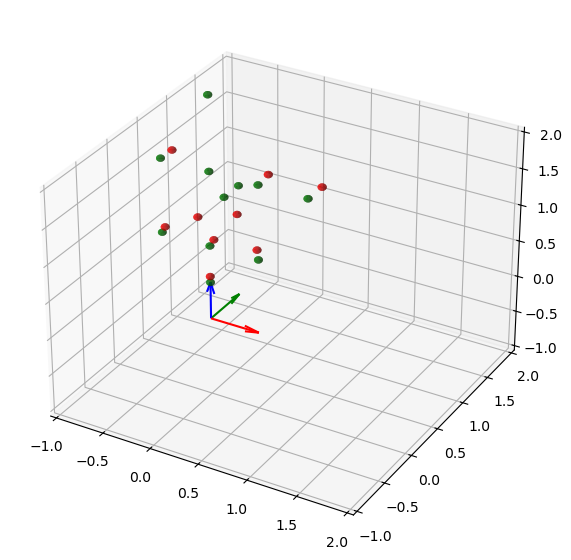

In [29]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-1, 2)
ax.set_ylim3d(-1, 2)
ax.set_zlim3d(-1, 2)

plot3D.plot_camera(ax, camera)
plot3D.plot_balls(ax, ball, actual_ball_positions, color='green')
plot3D.plot_balls(ax, ball, ball_positions, color='red')
plt.show()